## Imports & Variables

In [1]:
import librosa
import numpy
import pandas
import requests
import seaborn
import sklearn
import tensorflow

import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# List of all labels
labels = ["washing_hands", "shower", "flushing_toilet", "dishwasher", "washing_machine"]

## Data Collection & Feature Extraction

In [3]:
# Get list of all recordings
data = requests.get("https://dolphin-app-9sdeq.ondigitalocean.app/api/v1/recordings").json()

recordings = []

for recording in data:
    recordings.append({
        "path": f'../recordings/combined/{recording["name"]}',
        "label": recording["label"],
        "environment": recording["environment"]
    })

dataframe = pandas.json_normalize(recordings)

dataframe.head()

,path,label,environment
0,../recordings/combined/a196dbae-1f50-4d0e-b345...,washing_hands,marsberg
1,../recordings/combined/826e36b1-2a7e-4d22-9c81...,washing_hands,marsberg
2,../recordings/combined/9a6b6b01-e466-47fb-9fcc...,washing_hands,marsberg
3,../recordings/combined/84ee02e6-44d5-4ab3-b875...,washing_hands,marsberg
4,../recordings/combined/ec24c55a-39ec-4b36-86fe...,washing_hands,marsberg


In [4]:
# Generate MFCCs for each recording
def preprocess(dataframe):
    features = []
    for index, row in tqdm(dataframe.iterrows()):
        audio, sample_rate = librosa.load(row["path"])
        mfcc = librosa.feature.mfcc(y=audio, n_mfcc=24, sr=sample_rate)
        features.append(numpy.mean(mfcc.T, axis=0))
        
    dataframe["features"] = features
    
    return dataframe

dataframe = preprocess(dataframe)

119it [02:29,  1.26s/it]


In [5]:
# Filter dataframe to include only data from marsberg
dataframe_marsberg = dataframe[dataframe["environment"] == "marsberg"]
dataframe_duesseldorf = dataframe[dataframe["environment"] == "duesseldorf"]

## Recurrent Neural Network trained on data from _marsberg_

In [6]:
# Prepare and split data for training
x = numpy.array(dataframe_marsberg["features"].tolist())
y = numpy.array(dataframe_marsberg["label"].tolist())

x = numpy.expand_dims(x, axis=2)

label_encoder = sklearn.preprocessing.LabelEncoder()
y = to_categorical(label_encoder.fit_transform(y))

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.15, random_state=1)
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_train, y_train, test_size=0.15, random_state=1)

print(x_train.shape, x_test.shape, x_val.shape)

(51, 24, 1) (11, 24, 1) (9, 24, 1)


In [7]:
# Configure, compile, and fit model
input_shape=(24, 1)
model = keras.Sequential()
model.add(LSTM(40,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(80, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

history = model.fit(x_train, y_train, epochs=72, validation_data=(x_val, y_val), shuffle=False)

2022-09-20 19:25:26.069658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                6720      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 80)                3280      
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0

In [8]:
# Calculate accuracy on test dataset
test_accuracy=model.evaluate(x_test, y_test, verbose=0)
print(test_accuracy[1])

1.0


1/1 [==============================] - 0s 465ms/step


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

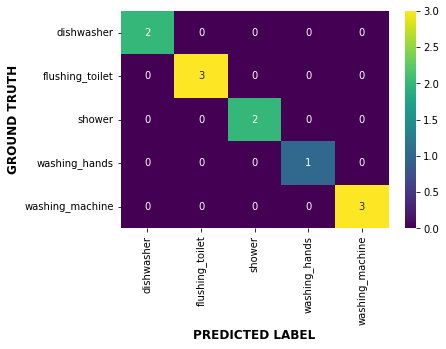

In [9]:
# Generate confusion matrix
y_true, y_pred = numpy.argmax(y_test, axis=1), numpy.argmax(model.predict(x_test), axis=1)

confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

def confusion_matrix_table(y_true, y_pred):
    columns = [label for label in label_encoder.classes_]
    index = [label for label in label_encoder.classes_]
    table = pandas.DataFrame(sklearn.metrics.confusion_matrix(y_true, y_pred), columns=columns, index=index)
    return table

def confusion_matrix_plot(y_true, y_pred):
    table = confusion_matrix_table(y_true, y_pred)
    plot = seaborn.heatmap(table, annot=True, fmt="d", cmap="viridis")
    plt.yticks(rotation=0) 
    plt.ylabel(
        'GROUND TRUTH', 
        fontsize = 12, 
        fontweight = 600
    )
    plt.xlabel(
        'PREDICTED LABEL', 
        fontsize = 12, 
        fontweight = 600
    )
    return plot

confusion_matrix_plot(y_true, y_pred)

In [10]:
# Calculate accuracy on data from duesseldorf
x_duesseldorf = numpy.array(dataframe_duesseldorf["features"].tolist())
y_duesseldorf = numpy.array(dataframe_duesseldorf["label"].tolist())

x_duesseldorf = numpy.expand_dims(x_duesseldorf, axis=2)

label_encoder = sklearn.preprocessing.LabelEncoder()
y_duesseldorf = to_categorical(label_encoder.fit_transform(y_duesseldorf))

test_accuracy=model.evaluate(x_duesseldorf, y_duesseldorf, verbose=0)
print(test_accuracy[1])

0.02083333395421505


2/2 [==============================] - 0s 6ms/step


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

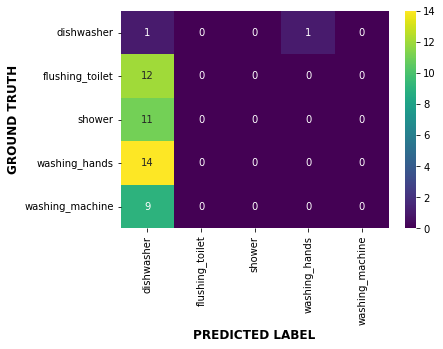

In [11]:
# Generate confusion matrix on data from duesseldorf
y_true, y_pred = numpy.argmax(y_duesseldorf, axis=1), numpy.argmax(model.predict(x_duesseldorf), axis=1)

confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

def confusion_matrix_table(y_true, y_pred):
    columns = [label for label in label_encoder.classes_]
    index = [label for label in label_encoder.classes_]
    table = pandas.DataFrame(sklearn.metrics.confusion_matrix(y_true, y_pred), columns=columns, index=index)
    return table

def confusion_matrix_plot(y_true, y_pred):
    table = confusion_matrix_table(y_true, y_pred)
    plot = seaborn.heatmap(table, annot=True, fmt="d", cmap="viridis")
    plt.yticks(rotation=0) 
    plt.ylabel(
        'GROUND TRUTH', 
        fontsize = 12, 
        fontweight = 600
    )
    plt.xlabel(
        'PREDICTED LABEL', 
        fontsize = 12, 
        fontweight = 600
    )
    return plot

confusion_matrix_plot(y_true, y_pred)

## Recurrent Neural Network trained on all data

In [12]:
# Prepare and split data for training
x_all = numpy.array(dataframe["features"].tolist())
y_all = numpy.array(dataframe["label"].tolist())

x_all = numpy.expand_dims(x_all, axis=2)

label_encoder = sklearn.preprocessing.LabelEncoder()
y_all = to_categorical(label_encoder.fit_transform(y_all))

x_all_train, x_all_test, y_all_train, y_all_test = sklearn.model_selection.train_test_split(x_all, y_all, test_size=0.15, random_state=1)
x_all_train, x_all_val, y_all_train, y_all_val = sklearn.model_selection.train_test_split(x_all_train, y_all_train, test_size=0.15, random_state=1)

print(x_all_train.shape, x_all_test.shape, x_all_val.shape)

(85, 24, 1) (18, 24, 1) (16, 24, 1)


In [13]:
# Configure, compile, and fit model
history_all = model.fit(x_all_train, y_all_train, epochs=72, validation_data=(x_all_val, y_all_val), shuffle=False)

Epoch 1/72
3/3 [==============================] - 0s 32ms/step - loss: 2.2038 - acc: 0.4941 - val_loss: 0.9548 - val_acc: 0.7500
Epoch 2/72
3/3 [==============================] - 0s 20ms/step - loss: 1.5687 - acc: 0.5529 - val_loss: 0.6999 - val_acc: 0.7500
Epoch 3/72
3/3 [==============================] - 0s 18ms/step - loss: 1.2653 - acc: 0.5412 - val_loss: 0.5605 - val_acc: 0.7500
Epoch 4/72
3/3 [==============================] - 0s 18ms/step - loss: 0.9831 - acc: 0.6000 - val_loss: 0.6025 - val_acc: 0.8125
Epoch 5/72
3/3 [==============================] - 0s 18ms/step - loss: 1.0123 - acc: 0.5412 - val_loss: 0.6421 - val_acc: 0.8125
Epoch 6/72
3/3 [==============================] - 0s 17ms/step - loss: 1.0033 - acc: 0.5529 - val_loss: 0.6550 - val_acc: 0.8125
Epoch 7/72
3/3 [==============================] - 0s 17ms/step - loss: 1.0819 - acc: 0.5294 - val_loss: 0.6348 - val_acc: 0.8125
Epoch 8/72
3/3 [==============================] - 0s 17ms/step - loss: 1.0339 - acc: 0.5294 - val

In [14]:
# Calculate accuracy on test dataset
test_accuracy=model.evaluate(x_all_test, y_all_test, verbose=0)
print(test_accuracy[1])

0.6666666865348816


1/1 [==============================] - 0s 25ms/step


<AxesSubplot:xlabel='PREDICTED LABEL', ylabel='GROUND TRUTH'>

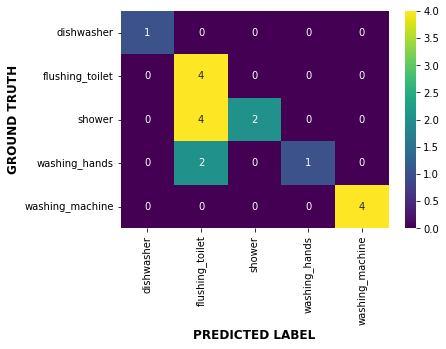

In [15]:
# Generate confusion matrix
y_all_true, y_all_pred = numpy.argmax(y_all_test, axis=1), numpy.argmax(model.predict(x_all_test), axis=1)

confusion_matrix_plot(y_all_true, y_all_pred)